#  Thinkpad X-series Price Analysis
This notebook serves to analyse all the unique listings on Ebay to understand the price trends for the portable 12\" X-series laptops

This notebook analyses the daily-collected price information from the ebay_spider scraper. Then using the aggregated data, observe what are the price trends for 2 types of laptops:
1. Complete working laptop
2. Parts-only laptop

## `listing` table schema

|column|description|
|:-|:-|
|id|primary key|
|title|seller assigned listing title|
|stars| out of 5.0 rating|
|condition|refurbished /parts only/pre-owned|
|price|in U.S. dollar|
|link|Listing URL from Ebay|
|cpu|i3/i5 / i7 |
|clock|CPU clock frequency(GHz) |
|ram| Memory (GB) |
|storage| HDD/SSD storage (GB)|
|has_dock| is dock included as described in title? |
|parts_only| these are defective units for parts harvesting. Usually much cheaper|
|has_missing| any missing components e.g. HDD, RAM, OS as declared in title? |
|machine_id| 1: X220, 2: X230, 3: X240 |
|is_auc| auction sale? or buy now? |

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
DBUSERNAME = #<your-username>
DBPASSWORD = #<your-password>
DBIP = #<your-db-ip>
DBNAME = #<your-db-name>

## Connecting to database
Using SQLAlchemy and pandas API to connect to Postgres DB on Amazon RDS.

In [2]:
sql_select = "select * from listing"
sql_conn = f"postgresql://{DBUSERNAME}:{DBPASSWORD}@{DBIP}:5432/{DBNAME}"

In [3]:
df = pd.read_sql_query(sql_select, sql_conn)

In [4]:
df.sample(5)

,id,title,stars,condition,price,link,cpu,clock,ram,storage,has_dock,parts_only,has_missing,machine_id,is_auc,date
46,1229,Lenovo ThinkPad Laptop X220 i5 2.5GHz 6GB 500G...,0.0,Refurbished,199.00,https://www.ebay.com/itm/Lenovo-ThinkPad-Lapto...,i5,2.5,6.0,500.0,0,0,0,1,0,2020-06-09
351,1534,Lenovo Thinkpad X240 i3 4Gb 500GB HDD AC Adapt...,0.0,Refurbished,223.33,https://www.ebay.com/itm/Lenovo-Thinkpad-X240-...,i3,NaN,4.0,500.0,0,0,0,3,0,2020-06-10
211,1394,Lenovo ThinkPad X230 i5-3360M 2.8GHz 4GB 320GB...,0.0,Pre-Owned,149.95,https://www.ebay.com/itm/Lenovo-ThinkPad-X230-...,i5,2.8,4.0,320.0,0,0,0,2,0,2020-06-09
344,1527,"Lenovo Thinkpad X240 12.5"" Notebook - Intel i5...",0.0,Refurbished,293.55,https://www.ebay.com/itm/Lenovo-Thinkpad-X240-...,i5,2.5,8.0,250.0,0,0,0,3,0,2020-06-10
377,1560,Lenovo Thinkpad laptop X240 i3 4GB RAM 160GB S...,5.0,Refurbished,250.00,https://www.ebay.com/itm/Lenovo-Thinkpad-lapto...,i3,NaN,4.0,160.0,0,0,0,3,0,2020-06-10


In [5]:
df.describe()

,id,stars,price,clock,ram,storage,has_dock,machine_id
count,492.000000,492.000000,492.000000,338.000000,422.000000,333.000000,492.000000,492.000000
mean,1428.500000,0.284553,261.992459,2.467456,6.962085,299.063063,0.036585,2.148374
std,142.172431,1.159537,193.250006,0.514254,4.945641,145.798029,0.187933,0.727925
min,1183.000000,0.000000,0.990000,1.600000,2.000000,120.000000,0.000000,1.000000
25%,1305.750000,0.000000,159.950000,2.500000,4.000000,180.000000,0.000000,2.000000
50%,1428.500000,0.000000,224.990000,2.500000,8.000000,256.000000,0.000000,2.000000
75%,1551.250000,0.000000,317.497500,2.600000,8.000000,500.000000,0.000000,3.000000
max,1674.000000,5.000000,1676.060000,8.100000,80.000000,750.000000,1.000000,3.000000


**Outlier analysis**
+ Value ranges for the columns of `ram`, `storage` are within reasonable values. And so are the categorial, integer and boolean-typed columns
+ Note that 1 unit is exceedingly expensive, priced at \$1676.06
+ A listing also quoted 8.1GHz for the CPU frequency, though this is an insignificant issue, since clock rates do not play a big role in the analysis

In [6]:
df.price[df.price > 999]

63     1256.87
64     1676.06
309    1676.06
310    1256.87
Name: price, dtype: float64

## 1. Distribution of prices for X-series models

In [7]:
df_pa = df[(df.price < 1000) & 
           (df.parts_only=='0') &
           (df.has_missing=='0') &
           (df.has_dock==0) &
           (df.is_auc=='0') &
           (df.date==dt.date(year=2020, month=6, day=10))].copy()

+ There are several listings priced at >\$1000. Probably these are bulk sales?
+ In order to not distort the distribution of prices, we eliminate units that are too expensive and contain missing parts.
+ By studying this distribution of prices in this second-hard market, I will know what's a reasonable price for the model that I'm buying.

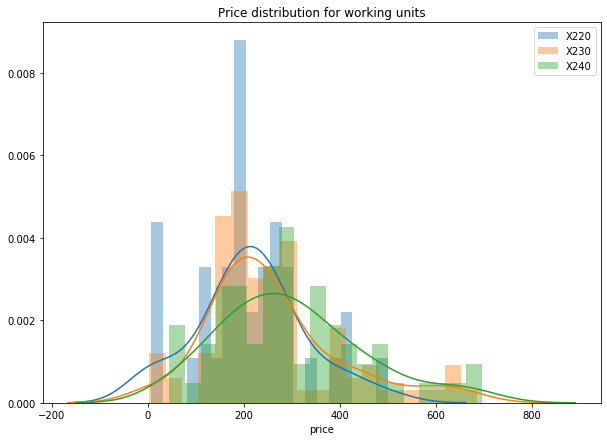

In [8]:
plt.figure(figsize=(10, 7))
sns.distplot(df_pa[df_pa.machine_id==1].price, bins=20, label='X220')
sns.distplot(df_pa[df_pa.machine_id==2].price, bins=20, label='X230')
sns.distplot(df_pa[df_pa.machine_id==3].price, bins=20, label='X240')
plt.title('Price distribution for working units')
plt.legend()
plt.show()

## 2. Prices for parts-only listings
I am also interested to know which are the best bargains among the defective units. Buy purchasing one unit, I can obtain spare parts for my beloved X-series

In [9]:
df_po = df[((df.parts_only=='1') | (df.has_missing=='1') | (df.condition=='Parts Only')) &
           (df.price < 200) & 
           (df.is_auc == '0') & 
           (df.date==dt.date(year=2020, month=6, day=10))].copy()

Text(0.5, 1.0, 'Price distribution for parts-only listings')

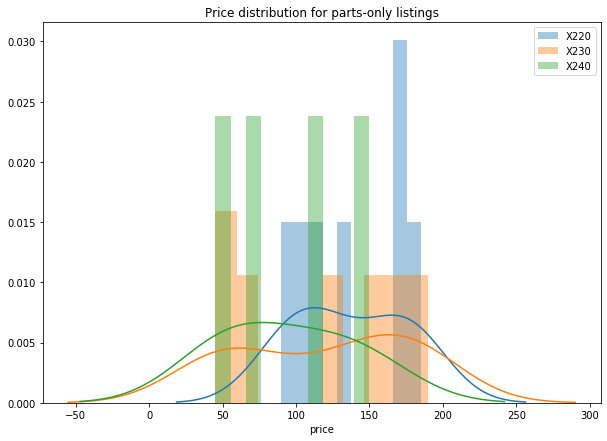

In [10]:
plt.figure(figsize=(10, 7))
sns.distplot(df_po[df_po.machine_id==1].price, bins=10, label='X220')
sns.distplot(df_po[df_po.machine_id==2].price, bins=10, label='X230')
sns.distplot(df_po[df_po.machine_id==3].price, bins=10, label='X240')
plt.legend()
plt.title('Price distribution for parts-only listings')